# Baseline network

This notebook trains the baseline network with exact same architecture as the one in paper [Recognition of handwritten Latin characters with diacritics using CNN](https://journals.pan.pl/dlibra/publication/136210/edition/119099/content/bulletin-of-the-polish-academy-of-sciences-technical-sciences-recognition-of-handwritten-latin-characters-with-diacritics-using-cnn-lukasik-edyta-charytanowicz-malgorzata-milosz-marek-tokovarov-michail-kaczorowska-monika-czerwinski-dariusz-zientarski-tomasz-2021-69-no-1?language=en)

Model architecture description:

- Input layer (32x32 grayscale image) 

- feature extraction
    - Conv2d (padding = 1, kernel = (3,3), stride = 1, activation = relu) 
    - MaxPool layer ( kernel=(2,2), stride=2) 
    - Conv2d layer (padding = 1, kernel = (3,3), stride = 1, activation = relu) 
    - MaxPool layer ( kernel=(2,2), stride=2) 

- dense layers
    - Dense(5376)
    - Dense(256)
    - Dense( number of classes - here in paper 89 classes)




After training, model is serialized and uploaded to W&B project.

In [1]:
import wandb
import tensorflow as tf
import numpy as np
import pathlib
import shutil
from typing import List

def load_data(run) -> List[tf.data.Dataset]:
    """
    Downloads datasets from a wandb artifact and loads them into a list of tf.data.Datasets.
    """

    artifact_name = f"letters_splits_tfds"
    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = pathlib.Path(
        f"./artifacts/{artifact.name.replace(':', '-')}"
    ).resolve()
    if not artifact_dir.exists():
        artifact_dir = artifact.download()
        artifact_dir = pathlib.Path(artifact_dir).resolve()

    # if tf.__version__ minor is less than 10, use
    # tf.data.experimental.load instead of tf.data.Dataset.load

    if int(tf.__version__.split(".")[1]) < 10:
        load_function = tf.data.experimental.load
    else:
        load_function = tf.data.Dataset.load
    
    output_list = []
    for split in ["train", "test", "val"]:
        ds = load_function(str(artifact_dir / split), compression="GZIP")
        output_list.append(ds)
    
    return output_list

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    labels_iterator= ds.map(lambda x, y: y).as_numpy_iterator()
    labels = np.concatenate(list(labels_iterator))
    return len(np.unique(labels))

def preprocess_dataset(ds: tf.data.Dataset, batch_size: int, cache: bool = True) -> tf.data.Dataset:
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
    ds = ds.unbatch().batch(batch_size)
    if cache:
        ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def calculate_model_size_on_disk(path: str) -> int:
    return pathlib.Path(path).stat().st_size    

def calculate_model_num_parameters(model: tf.keras.Model) -> int:
    return model.count_params()

def calculate_model_flops(model: tf.keras.Model) -> str:
    pass

2023-01-14 20:53:01.439535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 20:53:01.999479: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/wiktor/miniconda3/lib/
2023-01-14 20:53:01.999547: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/wiktor/miniconda3/lib/
2023-01-14 20:53:01.999552: W tensorflow/compiler/tf2tensorrt/utils/py

In [2]:
defaults = dict(
    batch_size=32*4,
    epochs=100,    
    optimizer="adam",
    learning_rate=0.001,
    beta1=0.9, 
    beta2=0.999, 
    epsilon=0.1
)

In [3]:
MODEL_NAME = "baseline-phcd"
run = wandb.init(project="master-thesis", job_type="training", name=MODEL_NAME, config=defaults,)

# hyperparameters

epochs = wandb.config.epochs
bs = wandb.config.batch_size

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


In [5]:
ds_train, ds_test, ds_val = load_data(run)

num_classes = get_number_of_classes(ds_val)

print(f"There are {num_classes} classes")
print(f"Training set has {len(ds_train)} batches")
print(f"Test set has {len(ds_test)} batches")
print(f"Validation set has {len(ds_val)} batches")

wandb:   9 of 9 files downloaded.  


/home/wiktor/code/master-thesis/notebooks/artifacts/letters_splits_tfds:v0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-14 20:53:06.098263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-14 20:53:06.102560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-14 20:53:06.102596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-14 20:53:06.102820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

There are 89 classes
Training set has 13953 batches
Test set has 1743 batches
Validation set has 1743 batches


In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Available devices: ", tf.config.list_physical_devices())


Num GPUs Available:  1
Available devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
ds_train = preprocess_dataset(ds_train, batch_size=bs)
ds_val = preprocess_dataset(ds_val, batch_size=bs)
ds_test = preprocess_dataset(ds_test, batch_size=bs, cache=False)

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
        tf.keras.layers.Conv2D(32,kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5376, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

opt = tf.keras.optimizers.get({
    'class_name': wandb.config.optimizer,
    'config': {
        'learning_rate': wandb.config.learning_rate,
        'beta_1': wandb.config.beta1,
        'beta_2': wandb.config.beta2,
        'epsilon': wandb.config.epsilon
    }
})

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"./artifacts/{MODEL_NAME}.h5",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

wandb_callback = wandb.keras.WandbCallback(
    save_model=False,
    compute_flops=True,
)

history = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[wandb_callback, checkpoint_callback],
)

2023-01-14 20:53:07.333095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-14 20:53:07.333136: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-14 20:53:07.333257: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-14 20:53:07.333543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-14 20:53:07.333575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-14 20:53:07.333595: I tensor

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Epoch 1/10


/home/wiktor/.pyenv/versions/3.10.9/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-01-14 20:53:08.520144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-14 20:53:08.953582: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-14 20:53:08.955647: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-14 20:53:08.955679: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-14 20:53:08.958112: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child pro

13953/13953 [==============================] - 124s 9ms/step - loss: 3.1827 - accuracy: 0.2812 - val_loss: 1.4596 - val_accuracy: 0.5851
Epoch 2/10
13953/13953 [==============================] - 123s 9ms/step - loss: 1.1730 - accuracy: 0.6523 - val_loss: 0.9631 - val_accuracy: 0.7051
Epoch 3/10
13953/13953 [==============================] - 120s 9ms/step - loss: 0.8766 - accuracy: 0.7223 - val_loss: 0.7918 - val_accuracy: 0.7461
Epoch 4/10
13953/13953 [==============================] - 121s 9ms/step - loss: 0.7570 - accuracy: 0.7514 - val_loss: 0.7101 - val_accuracy: 0.7666
Epoch 5/10
13953/13953 [==============================] - 123s 9ms/step - loss: 0.6918 - accuracy: 0.7677 - val_loss: 0.6578 - val_accuracy: 0.7801
Epoch 6/10
13953/13953 [==============================] - 138s 10ms/step - loss: 0.6481 - accuracy: 0.7790 - val_loss: 0.6204 - val_accuracy: 0.7889
Epoch 7/10
13953/13953 [==============================] - 164s 12ms/step - loss: 0.6155 - accuracy: 0.7878 - val_loss: 0.5

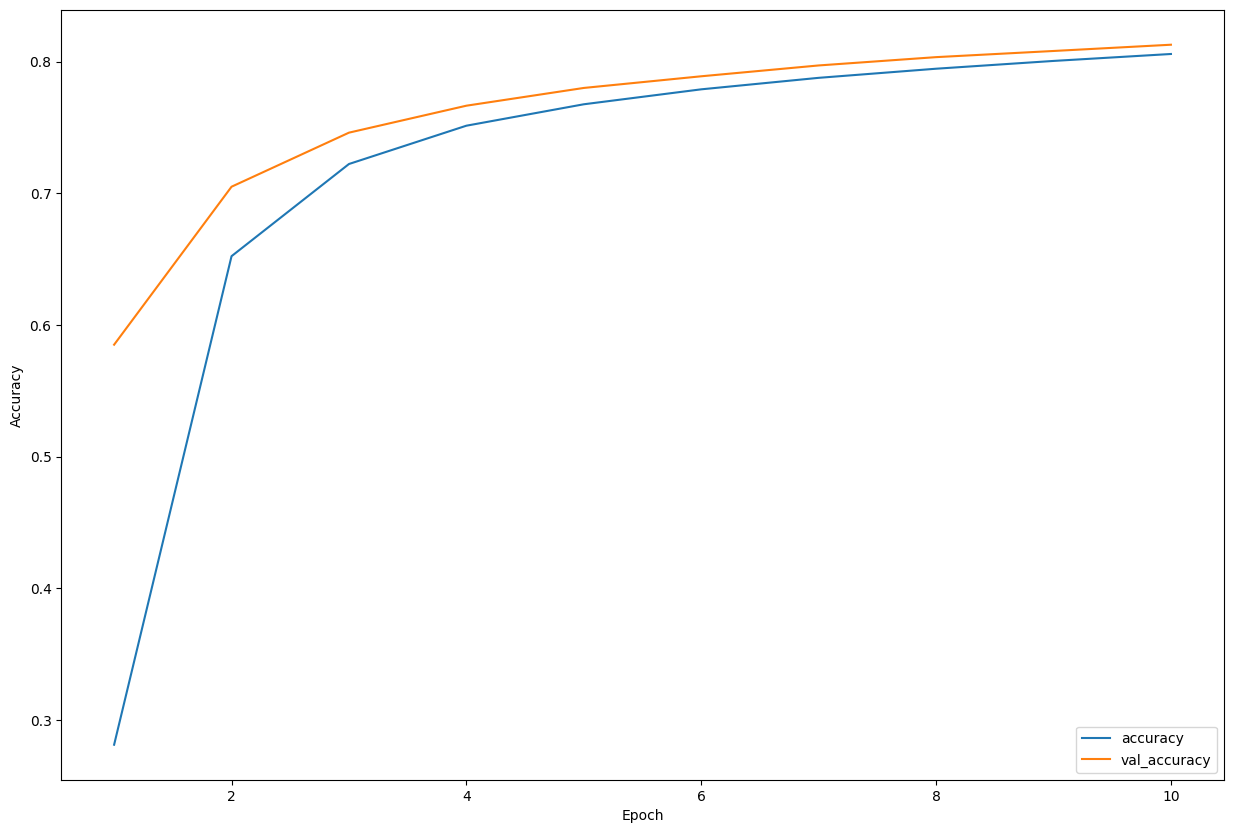

In [8]:
# plot history
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
epochs = range(1, len(history.history["loss"]) + 1)
ax.plot(epochs, history.history["accuracy"], label="accuracy")
ax.plot(epochs, history.history["val_accuracy"], label="val_accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc="lower right")

plt.show()

In [9]:
# calculate model size on disk, flops and number of parameters

flops = wandb.run.summary["GFLOPs"]
disk_size = calculate_model_size_on_disk(f"./artifacts/{MODEL_NAME}.h5")
num_parameters = calculate_model_num_parameters(model)

# evaluate model on ds_test and log to wandb
test_loss, test_acc = model.evaluate(ds_test)

wandb.log({
    "test loss": test_loss, 
    "test accuracy": test_acc, 
    "number of parameters": num_parameters,
    "disk size": disk_size, 
    "model flops": flops
    })


diacritics = {
    62: "ą",
    63: "ć",
    64: "ę",
    65: "ł",
    66: "ń",
    67: "ó",
    68: "ś",
    69: "ź",
    70: "ż",
    71: "Ą",
    72: "Ć",
    73: "Ę",
    74: "Ł",
    75: "Ń",
    76: "Ó",
    77: "Ś",
    78: "Ź",
    79: "Ż"
}

# log test accuracy on these classes separately to wandb

diacritics_acc = {}
for diacritic_label in diacritics.keys():
    ds_test_diacritic = ds_test.filter(lambda x, y: y == diacritic_label)
    test_loss, test_acc = model.evaluate(ds_test_diacritic)
    diacritics_acc[diacritic_label] = {
        "loss": test_loss,
        "accuracy": test_acc,
        "label": diacritics[diacritic_label],
    }

wandb.log(diacritics_acc)

1743/1743 [==============================] - 7s 4ms/step - loss: 0.5319 - accuracy: 0.8129


ValueError: Invalid `predicate`. `predicate` must return a `tf.bool` scalar tensor, but its return type is TensorSpec(shape=(None,), dtype=tf.bool, name=None).

In [ ]:
# save artifact to wandb
artifact = wandb.Artifact(
    name=MODEL_NAME,
    type="model"
)

# save best model to artifact
artifact.add_file(f"./artifacts/{MODEL_NAME}.h5")
run.log_artifact(artifact)
run.finish()